In [2]:
import os
import ast
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates
import statsmodels.api as sm # 用于统计检验
%matplotlib inline
plt.rcParams["font.sans-serif"]=["WenQuanYi Micro Hei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

## 参数选择

In [17]:
# # Parameters
# MODEL_INDEX = 2
# EMO_INDEX = 0
# N = 20

In [10]:
ORI_DATA_PATH = '/data/public/fintechlab/zdh/Individual-Stock-Analysis/B_Temporal_Clustering/data'
ROOT_PATH = '/data/public/fintechlab/zdh/Individual-Stock-Analysis/B_Result_Analysis'
CLUSTER_PATH = f'{ROOT_PATH}/data/Comparison_of_Emotional_models'

MODEL = ['Emo-Dict/DLUT', 'Emo-Dict/Bian', 'Emo-Dict/Jiang',
         'Machine-learning/LR', 'Machine-learning/RF', 'Machine-learning/SVM', 
         'Deep-learning/BERT', 'Deep-learning/Ours'][MODEL_INDEX]
Emotion_Data_PATH = f'{ORI_DATA_PATH}/Emotion_Data/{MODEL}'   # 情绪数据路径
Financial_Data_PATH = f'{ORI_DATA_PATH}/Financial_Data' # 金融数据路径

In [11]:
EMO_MARKET = ['Shanghai_Composite_Index', 'CSI_300_Index', 'Chinext_Index'][EMO_INDEX]
EMO_INDEX_MAP = {
    'Shanghai_Composite_Index': '上证综合情绪值',
    'CSI_300_Index': '沪深300情绪值',
    'Chinext_Index': '创业板情绪值'
}
EMO_NAME = EMO_INDEX_MAP[EMO_MARKET]

## 数据预处理

In [16]:
## 读取聚类结果
cluster_data = pd.read_csv(f'{CLUSTER_PATH}/{EMO_MARKET}/{MODEL}.csv', dtype={"Stkcd": str})
cluster_data.columns = ['股票编号', '聚类标签', '公司名称']

# 尝试抽样直到满足每个簇至少出现3次
for _ in range(100):
    cluster_data = cluster_data.sample(n=N, random_state=np.random.randint(0, 10000))
    label_counts = cluster_data['聚类标签'].value_counts()
    
    if all(label_counts >= 3):
        break
else:
    raise ValueError(f"在 {RETRY_LIMIT} 次尝试中无法找到满足每个簇至少3个样本的抽样结果，请减少 N 或检查数据分布。")

cluster_data.head()

股票编号  聚类标签  公司名称
14   000895     1  双汇发展
181  688029     1  南微医学
71   600009     0  上海机场
163  601899     2  紫金矿业
22   002142     0  宁波银行

In [44]:
## 读取股吧个股的数据
all_data = []
file_list = [f for f in os.listdir(Emotion_Data_PATH) if f.endswith('.csv')]

if MODEL != 'Deep-learning/Ours':
    for file in file_list:
        file_path = os.path.join(Emotion_Data_PATH, file)
        df = pd.read_csv(file_path)
        stock_code = os.path.splitext(file)[0] # 获取股票编号（文件名去掉扩展名）
        
        # 提取每一行的日期和情绪值
        for _, row in df.iterrows():
            new_row = {
                '股票编号': stock_code,
                '日期': row['日期'],
                '上证综合情绪值': row['上证综合情绪值'],
                '沪深300情绪值': row['沪深300情绪值'],
                '创业板情绪值': row['创业板情绪值']
            }
            all_data.append(new_row)
    guba_data = pd.DataFrame(all_data)
else:
    for file in tqdm(file_list, desc="读取文件"):
        file_path = os.path.join(Emotion_Data_PATH, file)
        try:
            df = pd.read_csv(file_path, usecols=['日期', '高维情绪变量'])  # 只读需要的列
        except Exception as e:
            print(f"读取失败 {file}: {e}")
            continue
    
        stock_code = os.path.splitext(file)[0]
    
        df['股票编号'] = stock_code
        all_data.append(df)
    guba_data = pd.concat(all_data, ignore_index=True)

guba_data

股票编号          日期   上证综合情绪值  沪深300情绪值    创业板情绪值
0       601933  2024-12-27  1.000000  1.000000  1.000000
1       601933  2024-11-18  0.000000  0.000000  0.000000
2       601933  2024-11-17  0.000000  0.000000  0.000000
3       601933  2024-11-17  0.000000  0.000000  0.000000
4       601933  2024-11-17  0.000000  0.000000  0.000000
...        ...         ...       ...       ...       ...
495326  601919  2021-04-09  1.000000  1.000000  1.000000
495327  601919  2021-04-09  0.000000  0.000000  0.000000
495328  601919  2021-04-08  0.333333  0.333333  0.333333
495329  601919  2021-04-08  1.000000  1.000000  1.000000
495330  601919  2021-01-01  0.000000  0.000000  0.000000

[495331 rows x 5 columns]

In [45]:
## 读取股票回报率的数据
return_data = pd.read_csv(f'{Financial_Data_PATH}/日个股回报率.csv', dtype={'股票编号': str})
return_data

股票编号          日期       交易量     收益率变化
0       000002  2021-06-01  60990961 -0.003745
1       000002  2021-06-02  85354506  0.006015
2       000002  2021-06-03  50594187 -0.003363
3       000002  2021-06-04  71422364 -0.012748
4       000002  2021-06-07  64745280 -0.014812
...        ...         ...       ...       ...
154877  688981  2024-11-20  58507495 -0.017071
154878  688981  2024-11-21  56197106  0.002358
154879  688981  2024-11-22  79240108 -0.050588
154880  688981  2024-11-25  76905909 -0.029402
154881  688981  2024-11-26  35363542 -0.012303

[154882 rows x 4 columns]

In [46]:
## 进行左连接，以 guba_data 为主表
merged_data = pd.merge(guba_data, return_data[['股票编号', '日期', '交易量', '收益率变化']], 
                       on=['股票编号', '日期'], 
                       how='left')
merged_data = pd.merge(merged_data, cluster_data, on='股票编号', how='left')
merged_data = merged_data.dropna()

merged_data['日期'] = pd.to_datetime(merged_data['日期'])
merged_data = merged_data[(merged_data['日期'] > '2021-05-06') & (merged_data['日期'] < '2024-11-18')]
merged_data

股票编号         日期  上证综合情绪值  沪深300情绪值  创业板情绪值          交易量     收益率变化  \
11      601933 2024-11-15     -1.0      -1.0    -1.0  423271473.0 -0.064655   
12      601933 2024-11-15     -1.0      -1.0    -1.0  423271473.0 -0.064655   
13      601933 2024-11-14      0.0       0.0     0.0  372259052.0 -0.053061   
14      601933 2024-11-14      0.0       0.0     0.0  372259052.0 -0.053061   
15      601933 2024-11-14     -1.0      -1.0    -1.0  372259052.0 -0.053061   
...        ...        ...      ...       ...     ...          ...       ...   
495148  601919 2021-06-01      1.0       1.0     1.0  268816321.0  0.045859   
495149  601919 2021-06-01      1.0       1.0     1.0  268816321.0  0.045859   
495150  601919 2021-06-01      1.0       1.0     1.0  268816321.0  0.045859   
495151  601919 2021-06-01      1.0       1.0     1.0  268816321.0  0.045859   
495152  601919 2021-06-01     -1.0      -1.0    -1.0  268816321.0  0.045859   

        聚类标签  公司名称  
11         2  永辉超市  
12         2  永辉超市  
13         2  永辉超市  
14         2  永辉超市  
15         2  永辉超市  
...      ...   ...  
495148     2  中远海控  
495149     2  中远海控  
495150     2  中远海控  
495151     2  中远海控  
495152     2  中远海控  

[391806 rows x 9 columns]

In [47]:
# 对情绪值列进行 Min-Max 标准化
def min_max_normalization(df, cols):
    for col in cols:
        min_val = df[col].min()
        max_val = df[col].max()
        df[col] = 2 * (df[col] - min_val) / (max_val - min_val) - 1
    return df

# 对每个股票编号的数据进行标准化和按日期汇总
def process_data(df):
    if MODEL != 'Deep-learning/Ours':
        df_processed = pd.DataFrame()  # 用于存储结果
        for stock_code, stock_data in df.groupby('股票编号'):
            # 对每个股票编号内的数据进行标准化
            stock_data = min_max_normalization(stock_data, ['上证综合情绪值', '沪深300情绪值', '创业板情绪值'])
            
            # 按日期汇总数据，同时保留股票编号
            stock_summary = stock_data.groupby('日期').agg({
                '股票编号': 'first',  # 保留股票编号（在同一日期内它是相同的，使用 'first'）
                '上证综合情绪值': 'mean',  # 上证综合情绪值按日期取均值
                '沪深300情绪值': 'mean',  # 沪深300情绪值按日期取均值
                '创业板情绪值': 'mean',  # 创业板情绪值按日期取均值
                '交易量': 'mean',  # 交易量按日期求和
                '收益率变化': 'mean',  # 收益率变化按日期取均值
                '聚类标签': 'first', # 保留聚类标签（在同一日期内它是相同的，使用 'first'）
                '公司名称': 'first', # 保留公司名称（在同一日期内它是相同的，使用 'first'）
            }).reset_index(drop=False)
            
            # 合并每个股票的汇总数据
            df_processed = pd.concat([df_processed, stock_summary], ignore_index=True)
            df_processed = df_processed.sort_values(by=['股票编号', '日期'], ascending=[True, True])
        return df_processed
    else:
        df_processed = []    
        # 确保高维情绪变量是 list 类型（如果还没转过）
        if isinstance(df['高维情绪变量'].iloc[0], str):
            df['高维情绪变量'] = df['高维情绪变量'].progress_apply(ast.literal_eval)
        # 对每个股票编号处理，加 tqdm 进度条
        for stock_code, stock_data in tqdm(df.groupby('股票编号'), desc="Processing stocks"):
            for date, group in stock_data.groupby('日期'):
                emotion_matrix = np.array(group['高维情绪变量'].tolist())  # (样本数, 维度)

                avg_emotion = emotion_matrix.mean(axis=0).round(3).tolist()

                summary_row = {
                    '股票编号': stock_code,
                    '日期': date,
                    '高维情绪变量': avg_emotion,
                    '交易量': group['交易量'].mean(),
                    '收益率变化': group['收益率变化'].mean(),
                    '聚类标签': group['聚类标签'].iloc[0], # 保留聚类标签
                    '公司名称': group['公司名称'].iloc[0], # 保留公司名称
                }
                df_processed.append(summary_row)


    return pd.DataFrame(df_processed)

final_data = process_data(merged_data)
final_data

日期    股票编号   上证综合情绪值  沪深300情绪值    创业板情绪值          交易量     收益率变化  \
0     2021-06-01  000002 -0.250000 -0.250000 -0.250000   60990961.0 -0.003745   
1     2021-06-08  000002  0.000000  0.000000  0.000000   44676494.0  0.004626   
2     2021-06-10  000002 -0.311111 -0.311111 -0.311111   53800776.0 -0.010035   
3     2021-06-11  000002 -0.333333 -0.333333 -0.333333   75853738.0 -0.014035   
4     2021-06-15  000002 -1.000000 -1.000000 -1.000000   89915501.0 -0.020957   
...          ...     ...       ...       ...       ...          ...       ...   
85668 2024-11-11  688981  0.666667  0.666667  0.666667  138069018.0  0.046660   
85669 2024-11-12  688981  0.111111  0.111111  0.111111  108866759.0 -0.036864   
85670 2024-11-13  688981  0.300000  0.300000  0.300000   80759477.0 -0.019484   
85671 2024-11-14  688981  0.400000  0.400000  0.400000   76194102.0 -0.022897   
85672 2024-11-15  688981  0.250000  0.250000  0.250000   71066743.0 -0.020233   

       聚类标签  公司名称  
0         2   万科A  
1         2   万科A  
2         2   万科A  
3         2   万科A  
4         2   万科A  
...     ...   ...  
85668     2  中芯国际  
85669     2  中芯国际  
85670     2  中芯国际  
85671     2  中芯国际  
85672     2  中芯国际  

[85673 rows x 9 columns]

In [48]:
# 统计检验 : 按照聚类标签分组，并计算均值和方差
df = final_data.copy()
if MODEL != 'Deep-learning/Ours':
    statistical_result = df.groupby('聚类标签').agg(
        情绪值均值=(EMO_NAME, 'mean'),
        情绪值方差=(EMO_NAME, 'var'),
        收益率变化均值=('收益率变化', 'mean'),
        收益率变化方差=('收益率变化', 'var')
    ).reset_index()
else:
    statistical_result = None
# 输出结果
statistical_result

聚类标签     情绪值均值     情绪值方差   收益率变化均值   收益率变化方差
0     0  0.182895  0.294075  0.000656  0.000701
1     1  0.181734  0.339079  0.001399  0.000826
2     2  0.163214  0.193386  0.000256  0.000728

## 情绪值与股价二维展示图

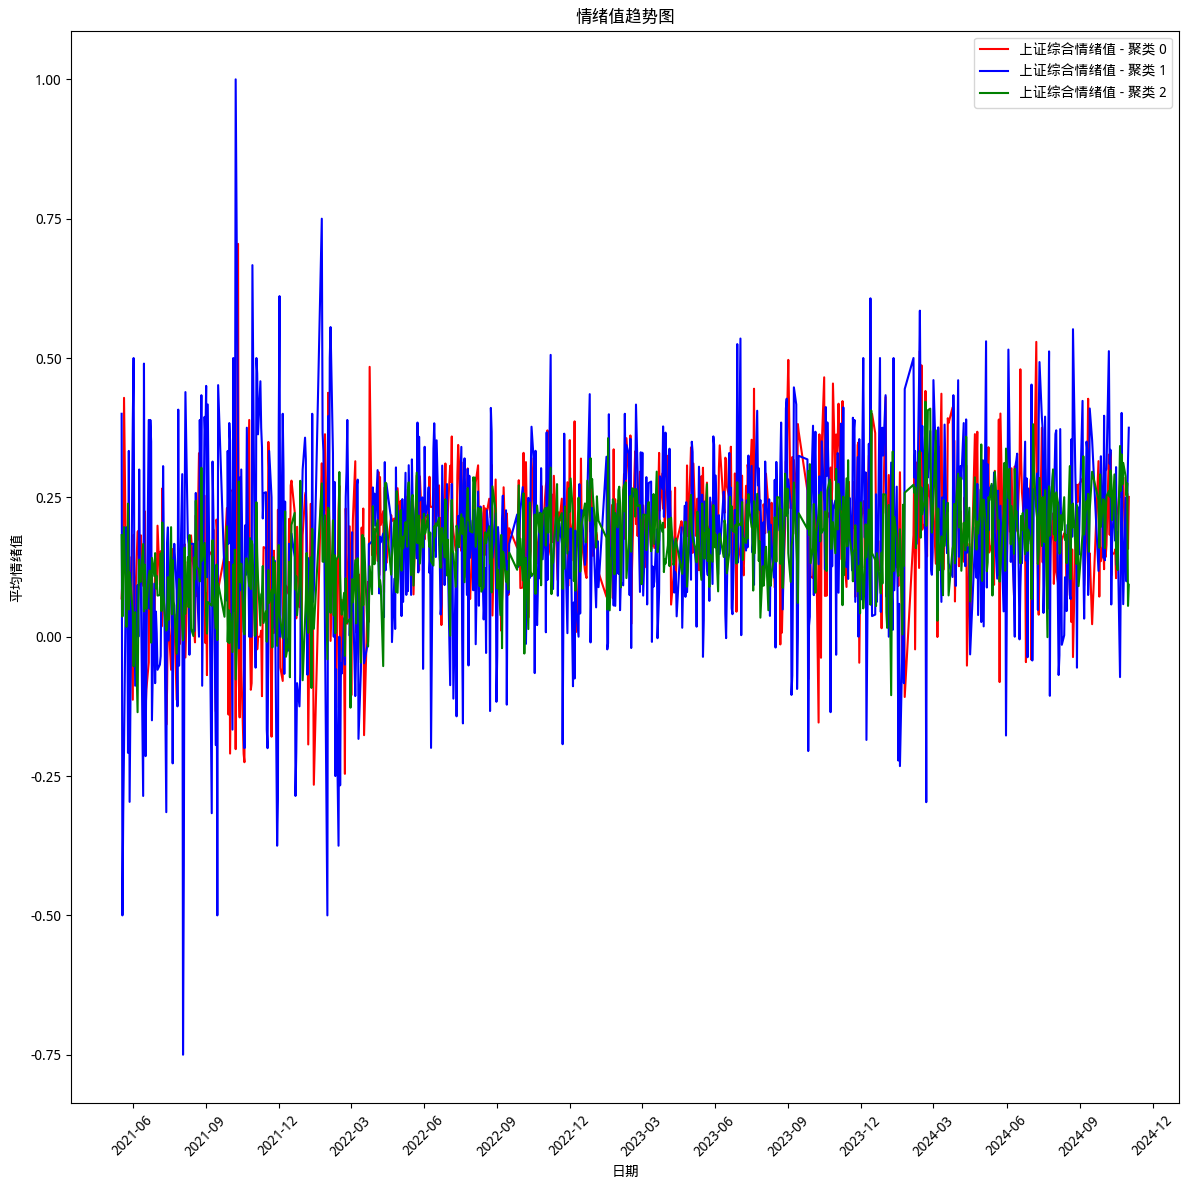

In [49]:
## 绘制不同簇情绪值随时间变化图
if MODEL != 'Deep-learning/Ours':
    # 按 '聚类标签' 和 '日期' 分组，计算平均情绪值
    df_grouped = final_data.groupby(['聚类标签', '日期'])[['上证综合情绪值', '沪深300情绪值', '创业板情绪值']].mean().reset_index()
    
    # 为每个聚类标签绘制折线
    i = 0
    plt.figure(figsize=(12, 12))
    for cluster in df_grouped['聚类标签'].unique():
        if i == 0:
            x = 'red'
        elif i == 1:
            x = 'blue'
        elif i == 2:
            x = 'green'
        df_cluster = df_grouped[df_grouped['聚类标签'] == cluster]
        plt.plot(df_cluster['日期'], df_cluster[EMO_NAME], label=f'{EMO_NAME} - 聚类 {cluster}', color=x)
        i += 1
        
    plt.xlabel('日期')
    plt.ylabel('平均情绪值')
    plt.title('情绪值趋势图')
    
    
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=15, interval=3))  # 每三个月显示
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 格式化为年-月
    
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    
    # plt.savefig(f'个股分析/{market_address}/图片/情绪值趋势图', dpi=300)
    plt.show()


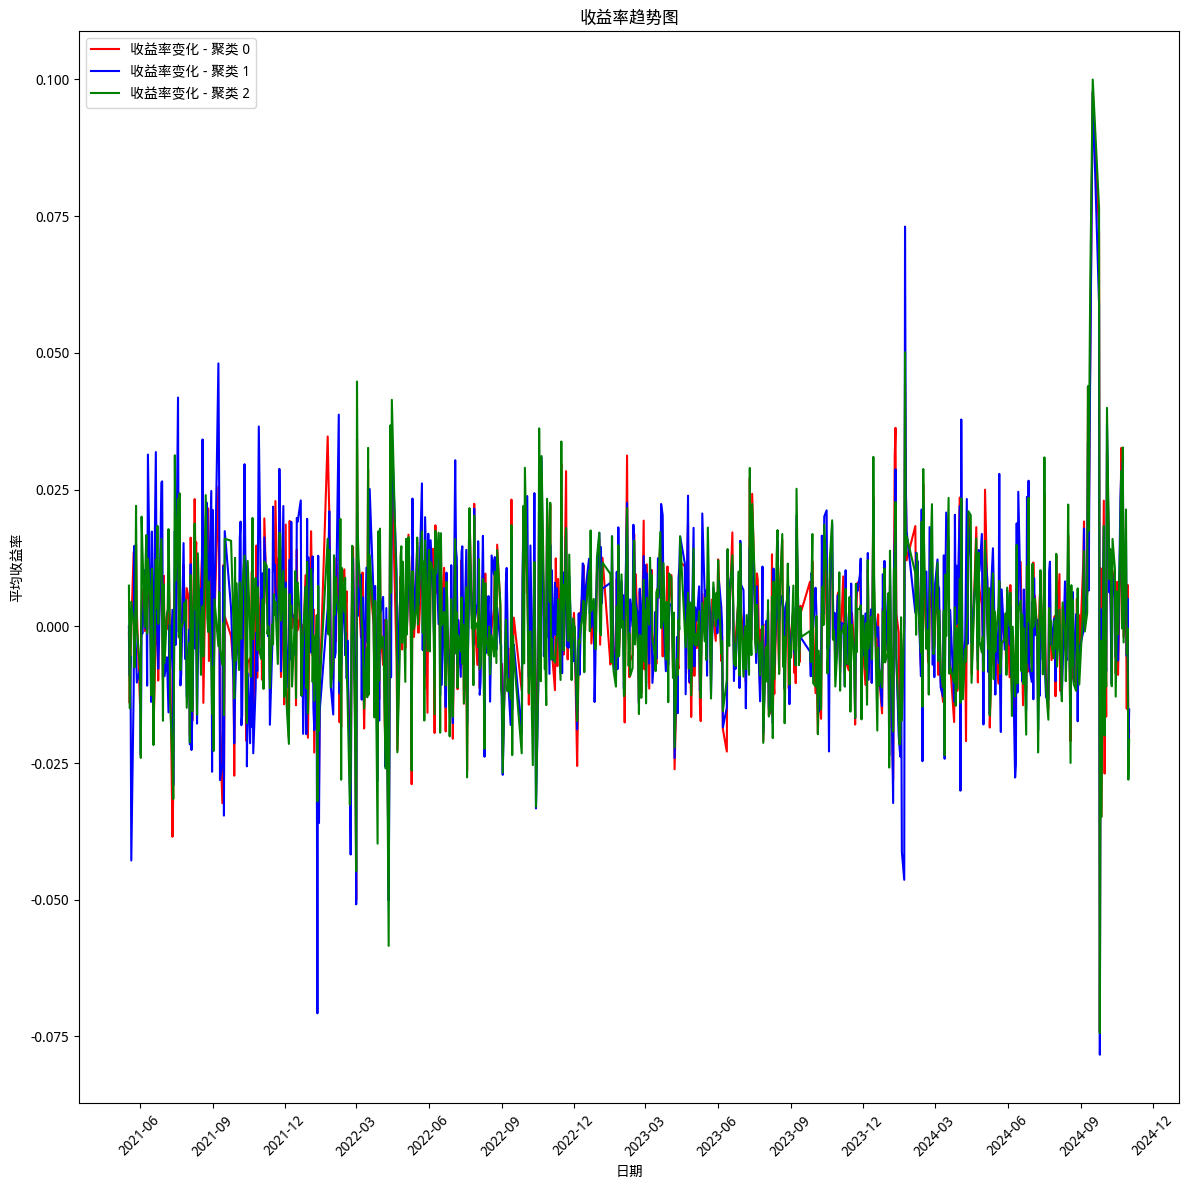

In [50]:
## 绘制不同簇收益率随时间变化图
if MODEL != 'Deep-learning/Ours':
    # 按 '聚类标签' 和 '日期' 分组，计算平均收益率
    return_grouped = final_data.groupby(['聚类标签', '日期'])['收益率变化'].mean().reset_index()
    
    # 为每个聚类标签绘制折线
    i = 0
    plt.figure(figsize=(12, 12))
    for cluster in df_grouped['聚类标签'].unique():
        if i == 0:
            x = 'red'
        elif i == 1:
            x = 'blue'
        elif i == 2:
            x = 'green'
        df_cluster = return_grouped[return_grouped['聚类标签'] == cluster]
        plt.plot(df_cluster['日期'], df_cluster['收益率变化'], label=f'收益率变化 - 聚类 {cluster}', color=x)
        i += 1
    
    plt.xlabel('日期')
    plt.ylabel('平均收益率')
    plt.title('收益率趋势图')
    
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=15, interval=3))  # 每三个月显示
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 格式化为年-月
    
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    
    # 显示图表
    # plt.savefig(f'个股分析/{market_address}/图片/收益率趋势图', dpi=300)
    plt.show()

## 三维展示图，分别展示簇是0，1，2的代表图

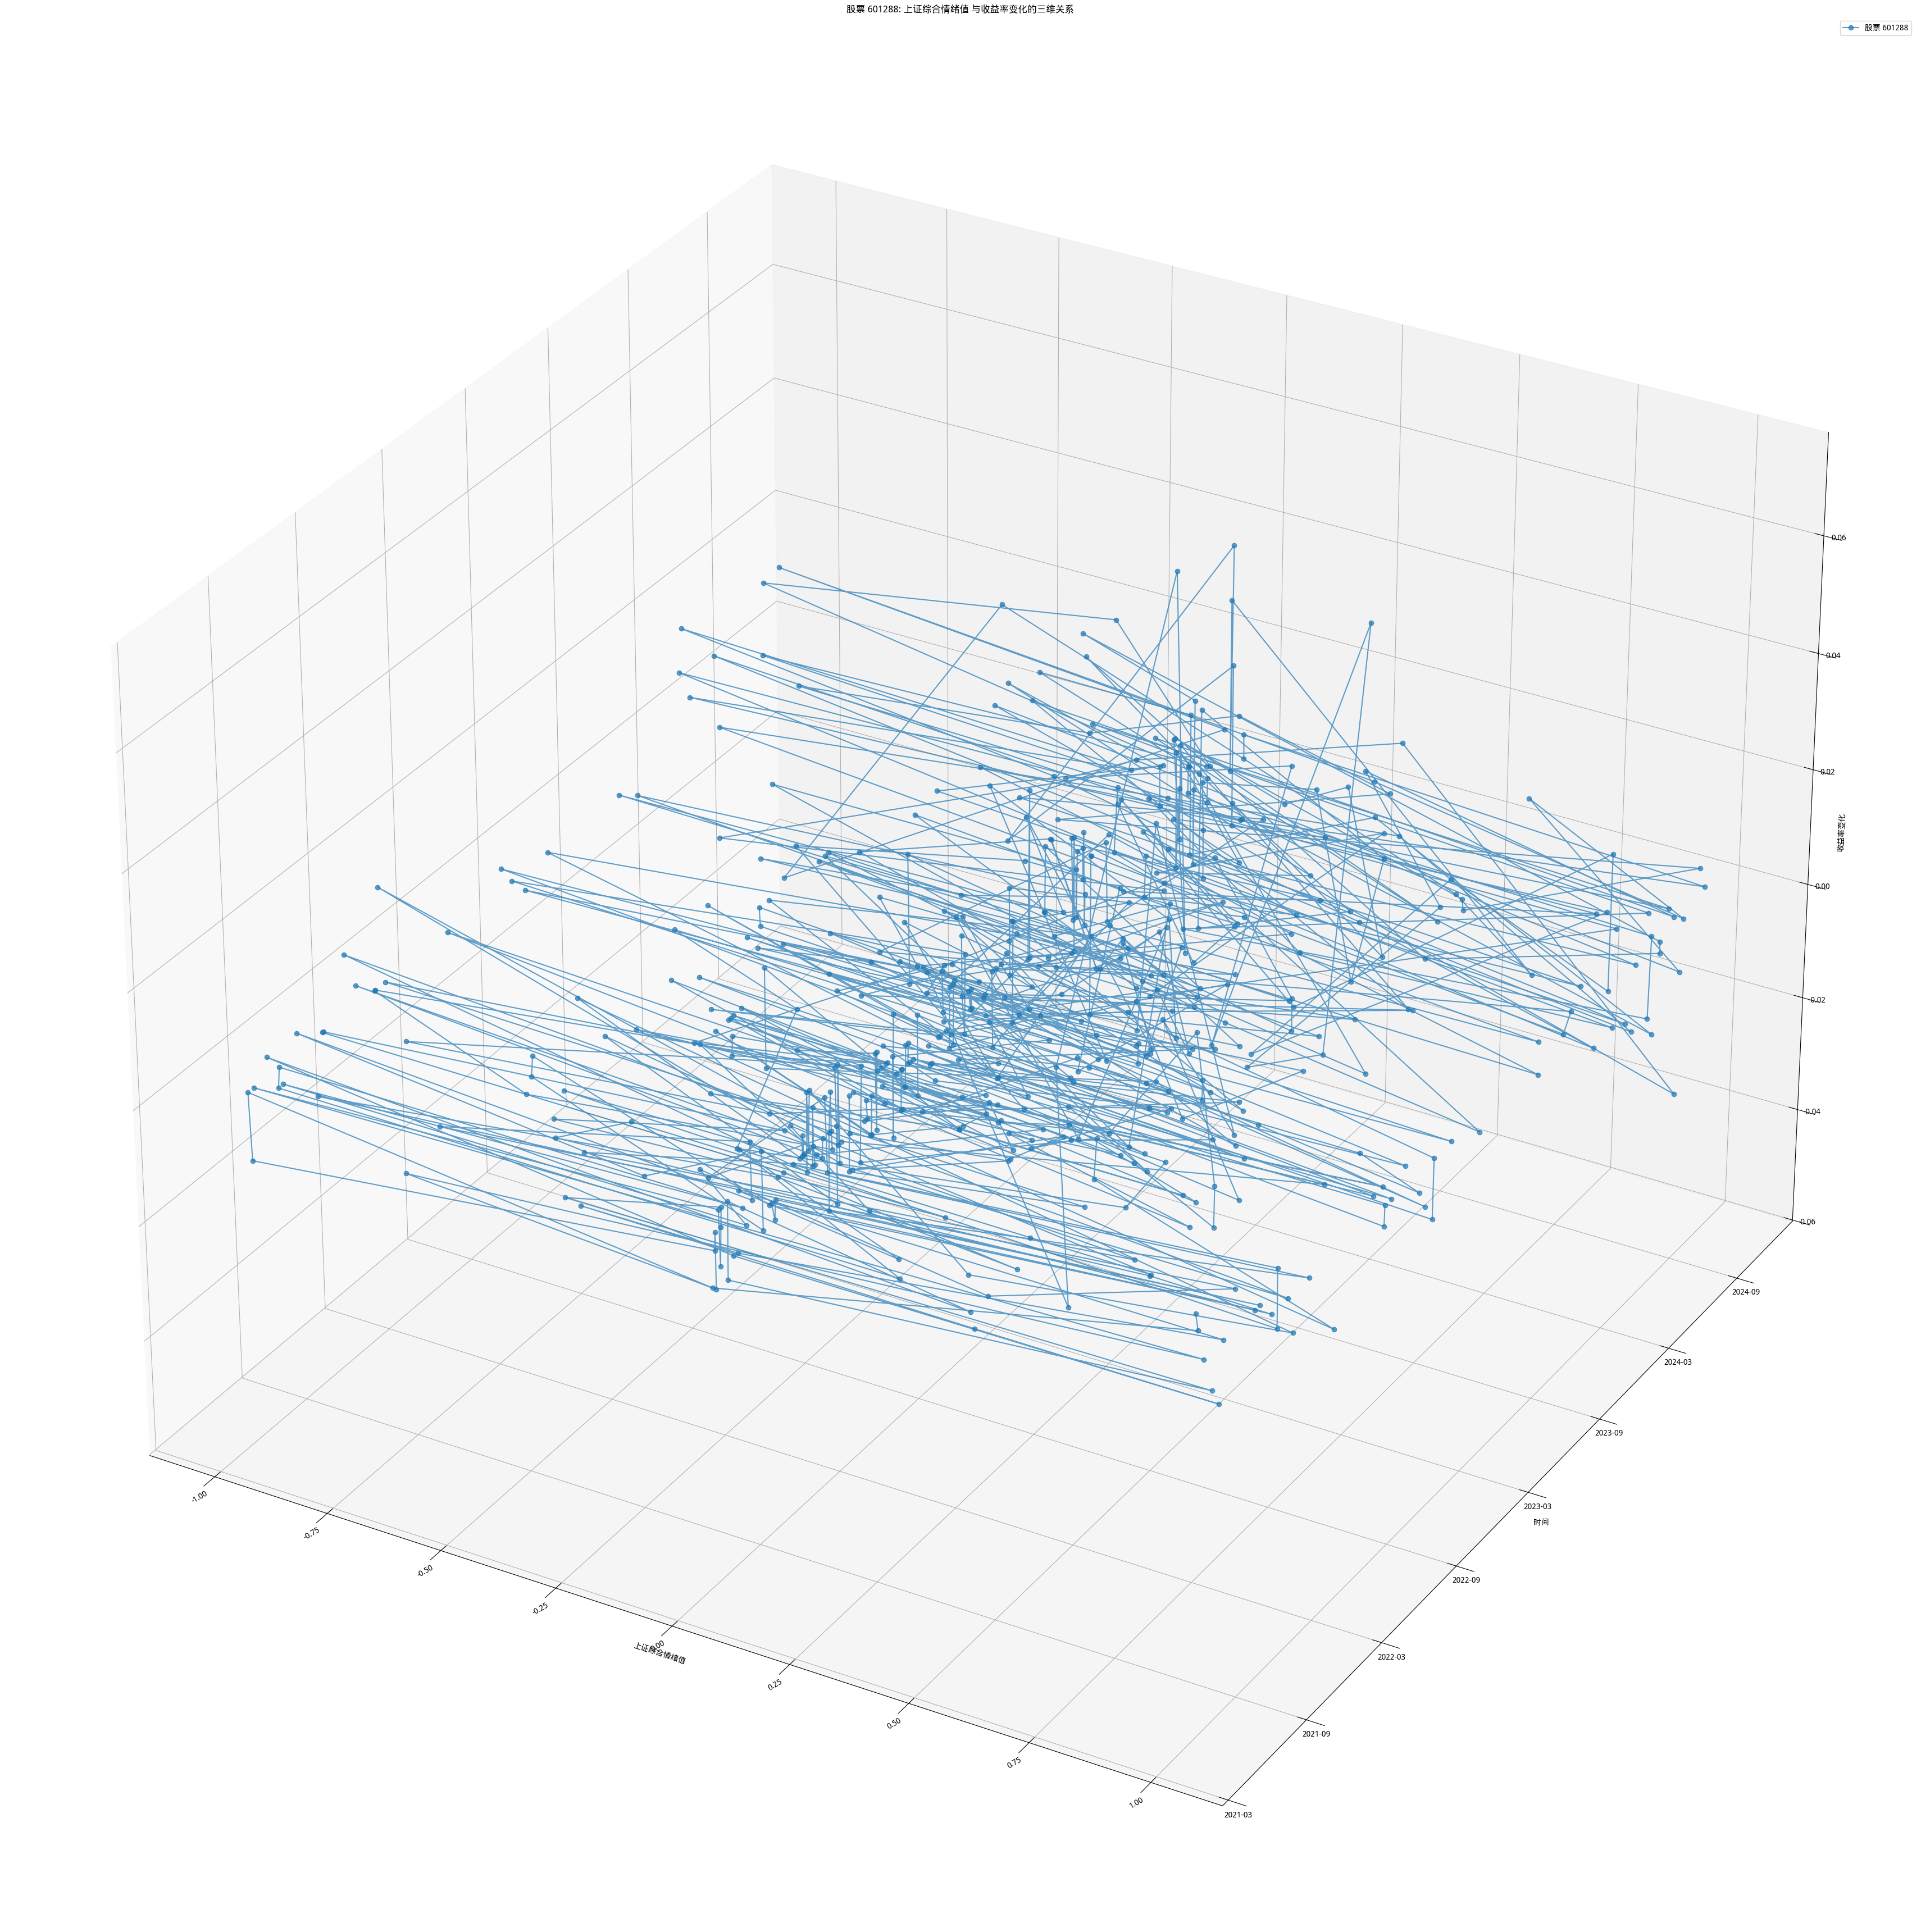

In [51]:
### 聚类0示例 ###
if MODEL != 'Deep-learning/Ours':
    # 复制数据集，确保不会修改原始数据
    merged_data_cleaned = final_data.copy()
    merged_data_cleaned['日期'] = pd.to_datetime(merged_data_cleaned['日期'])
    
    # 选择聚类标签为 0 的数据，找到数据最多的股票编号
    cluster_0_data = merged_data_cleaned[merged_data_cleaned['聚类标签'] == 0]
    top_stock_code = cluster_0_data['股票编号'].value_counts().idxmax()
    top_stock_data = cluster_0_data[cluster_0_data['股票编号'] == top_stock_code]
    
    # 创建 3D 图
    fig = plt.figure(figsize=(50, 50))
    ax = fig.add_subplot(111, projection='3d')
    
    # 提取绘图数据
    x = top_stock_data[EMO_NAME]  # 情绪值作为 x 轴
    y = mdates.date2num(top_stock_data['日期'])  # 时间转换为数值类型
    z = top_stock_data['收益率变化']  # 收益率变化作为 z 轴
    
    # 绘制三维折线图
    ax.plot(x, y, z, label=f"股票 {top_stock_code}", marker='o', linestyle='-', alpha=0.7)
    
    # 设置轴标签
    ax.set_xlabel(EMO_NAME)
    ax.set_ylabel('时间')
    ax.set_zlabel('收益率变化')
    ax.set_title(f'股票 {top_stock_code}: {EMO_NAME} 与收益率变化的三维关系')
    
    # 设置 y 轴时间刻度（每半年一个刻度）
    ax.yaxis.set_major_locator(mdates.MonthLocator(bymonthday=15, interval=6))  # 每半年一个刻度
    ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 按年月显示
    
    # 旋转日期标签防止重叠
    fig.autofmt_xdate()
    
    # 调整布局并保存图像
    plt.legend()
    # plt.savefig(f'个股分析/{market_address}/图片/聚类0_{top_stock_code}.png', dpi=300, bbox_inches='tight')
    plt.show()


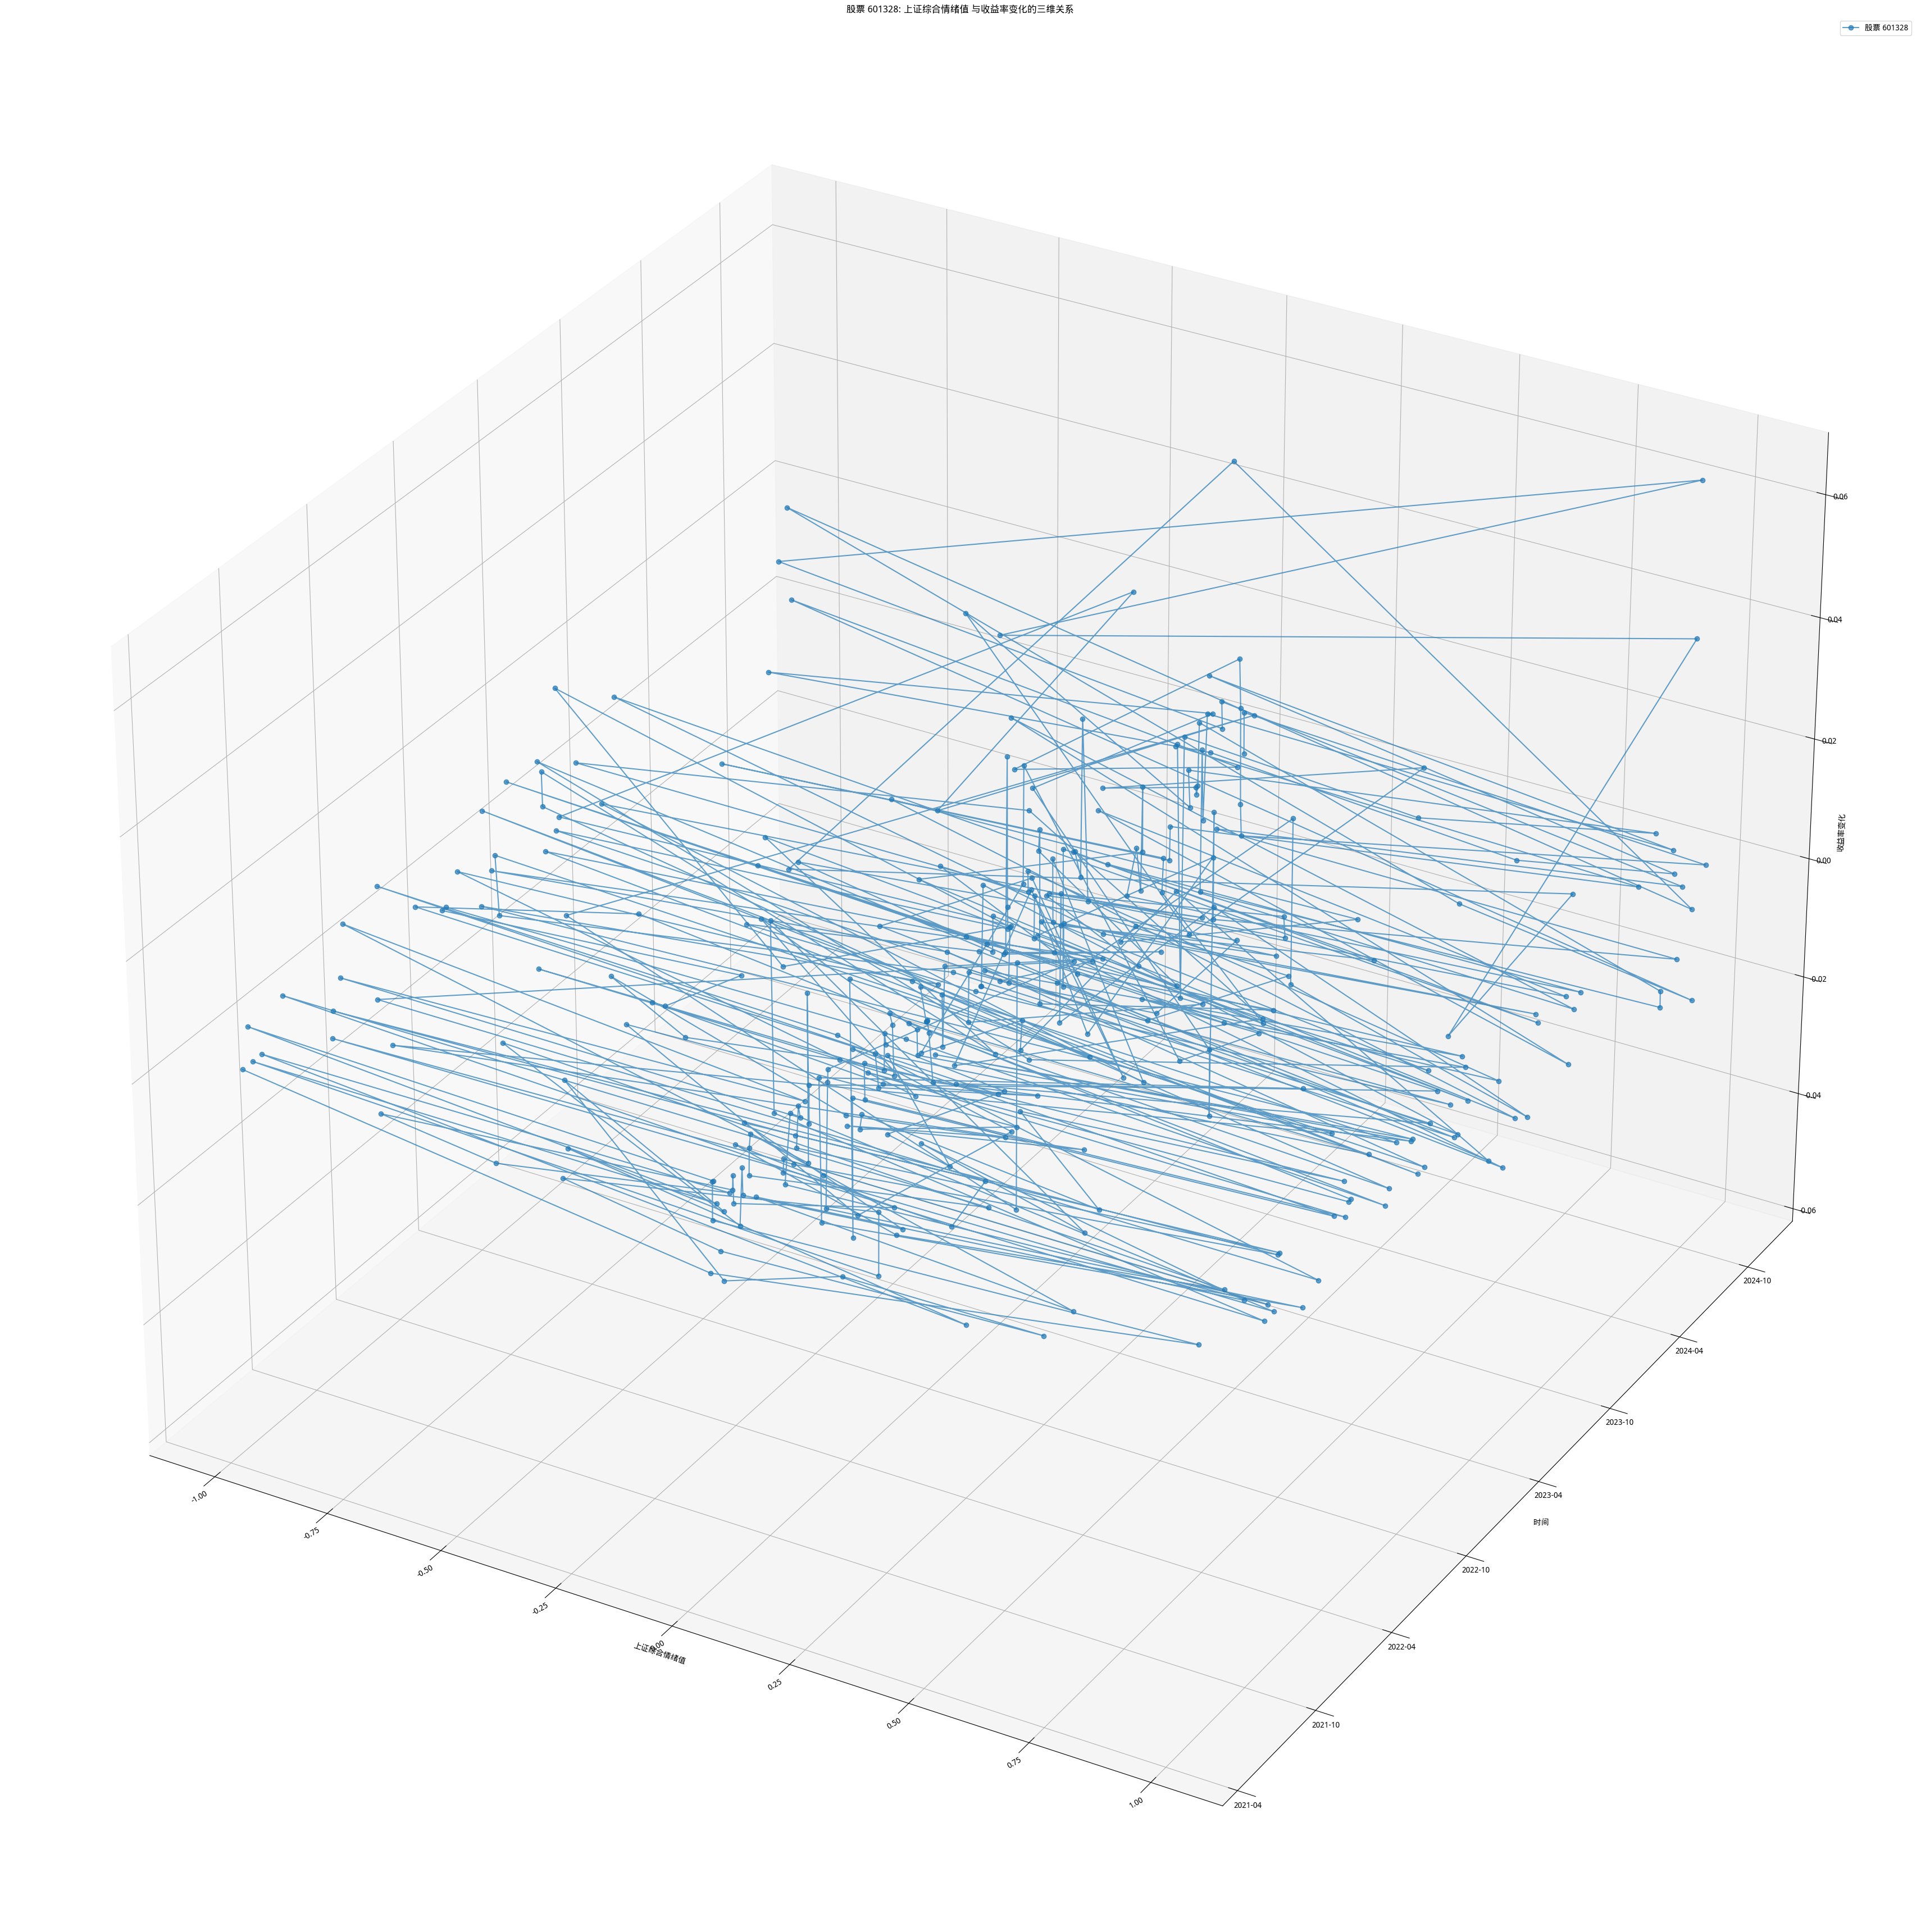

In [52]:
### 聚类1示例 ###
if MODEL != 'Deep-learning/Ours':
    # 复制数据集，确保不会修改原始数据
    merged_data_cleaned = final_data.copy()
    merged_data_cleaned['日期'] = pd.to_datetime(merged_data_cleaned['日期'])
    
    # 选择聚类标签为 0 的数据，找到数据最多的股票编号
    cluster_0_data = merged_data_cleaned[merged_data_cleaned['聚类标签'] == 1]
    top_stock_code = cluster_0_data['股票编号'].value_counts().idxmax()
    top_stock_data = cluster_0_data[cluster_0_data['股票编号'] == top_stock_code]
    
    
    # 创建 3D 图
    fig = plt.figure(figsize=(50, 50))
    ax = fig.add_subplot(111, projection='3d')
    
    # 提取绘图数据
    x = top_stock_data[EMO_NAME]  # 情绪值作为 x 轴
    y = mdates.date2num(top_stock_data['日期'])  # 时间转换为数值类型
    z = top_stock_data['收益率变化']  # 收益率变化作为 z 轴
    
    # 绘制三维折线图
    ax.plot(x, y, z, label=f"股票 {top_stock_code}", marker='o', linestyle='-', alpha=0.7)
    
    # 设置轴标签
    ax.set_xlabel(EMO_NAME)
    ax.set_ylabel('时间')
    ax.set_zlabel('收益率变化')
    ax.set_title(f'股票 {top_stock_code}: {EMO_NAME} 与收益率变化的三维关系')
    
    # 设置 y 轴时间刻度（每半年一个刻度）
    ax.yaxis.set_major_locator(mdates.MonthLocator(bymonthday=15, interval=6))  # 每半年一个刻度
    ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 按年月显示
    
    # 旋转日期标签防止重叠
    fig.autofmt_xdate()
    
    # 调整布局并保存图像
    plt.legend()
    # plt.savefig(f'个股分析/{market_address}/图片/聚类1_{top_stock_code}.png', dpi=300, bbox_inches='tight')
    plt.show()


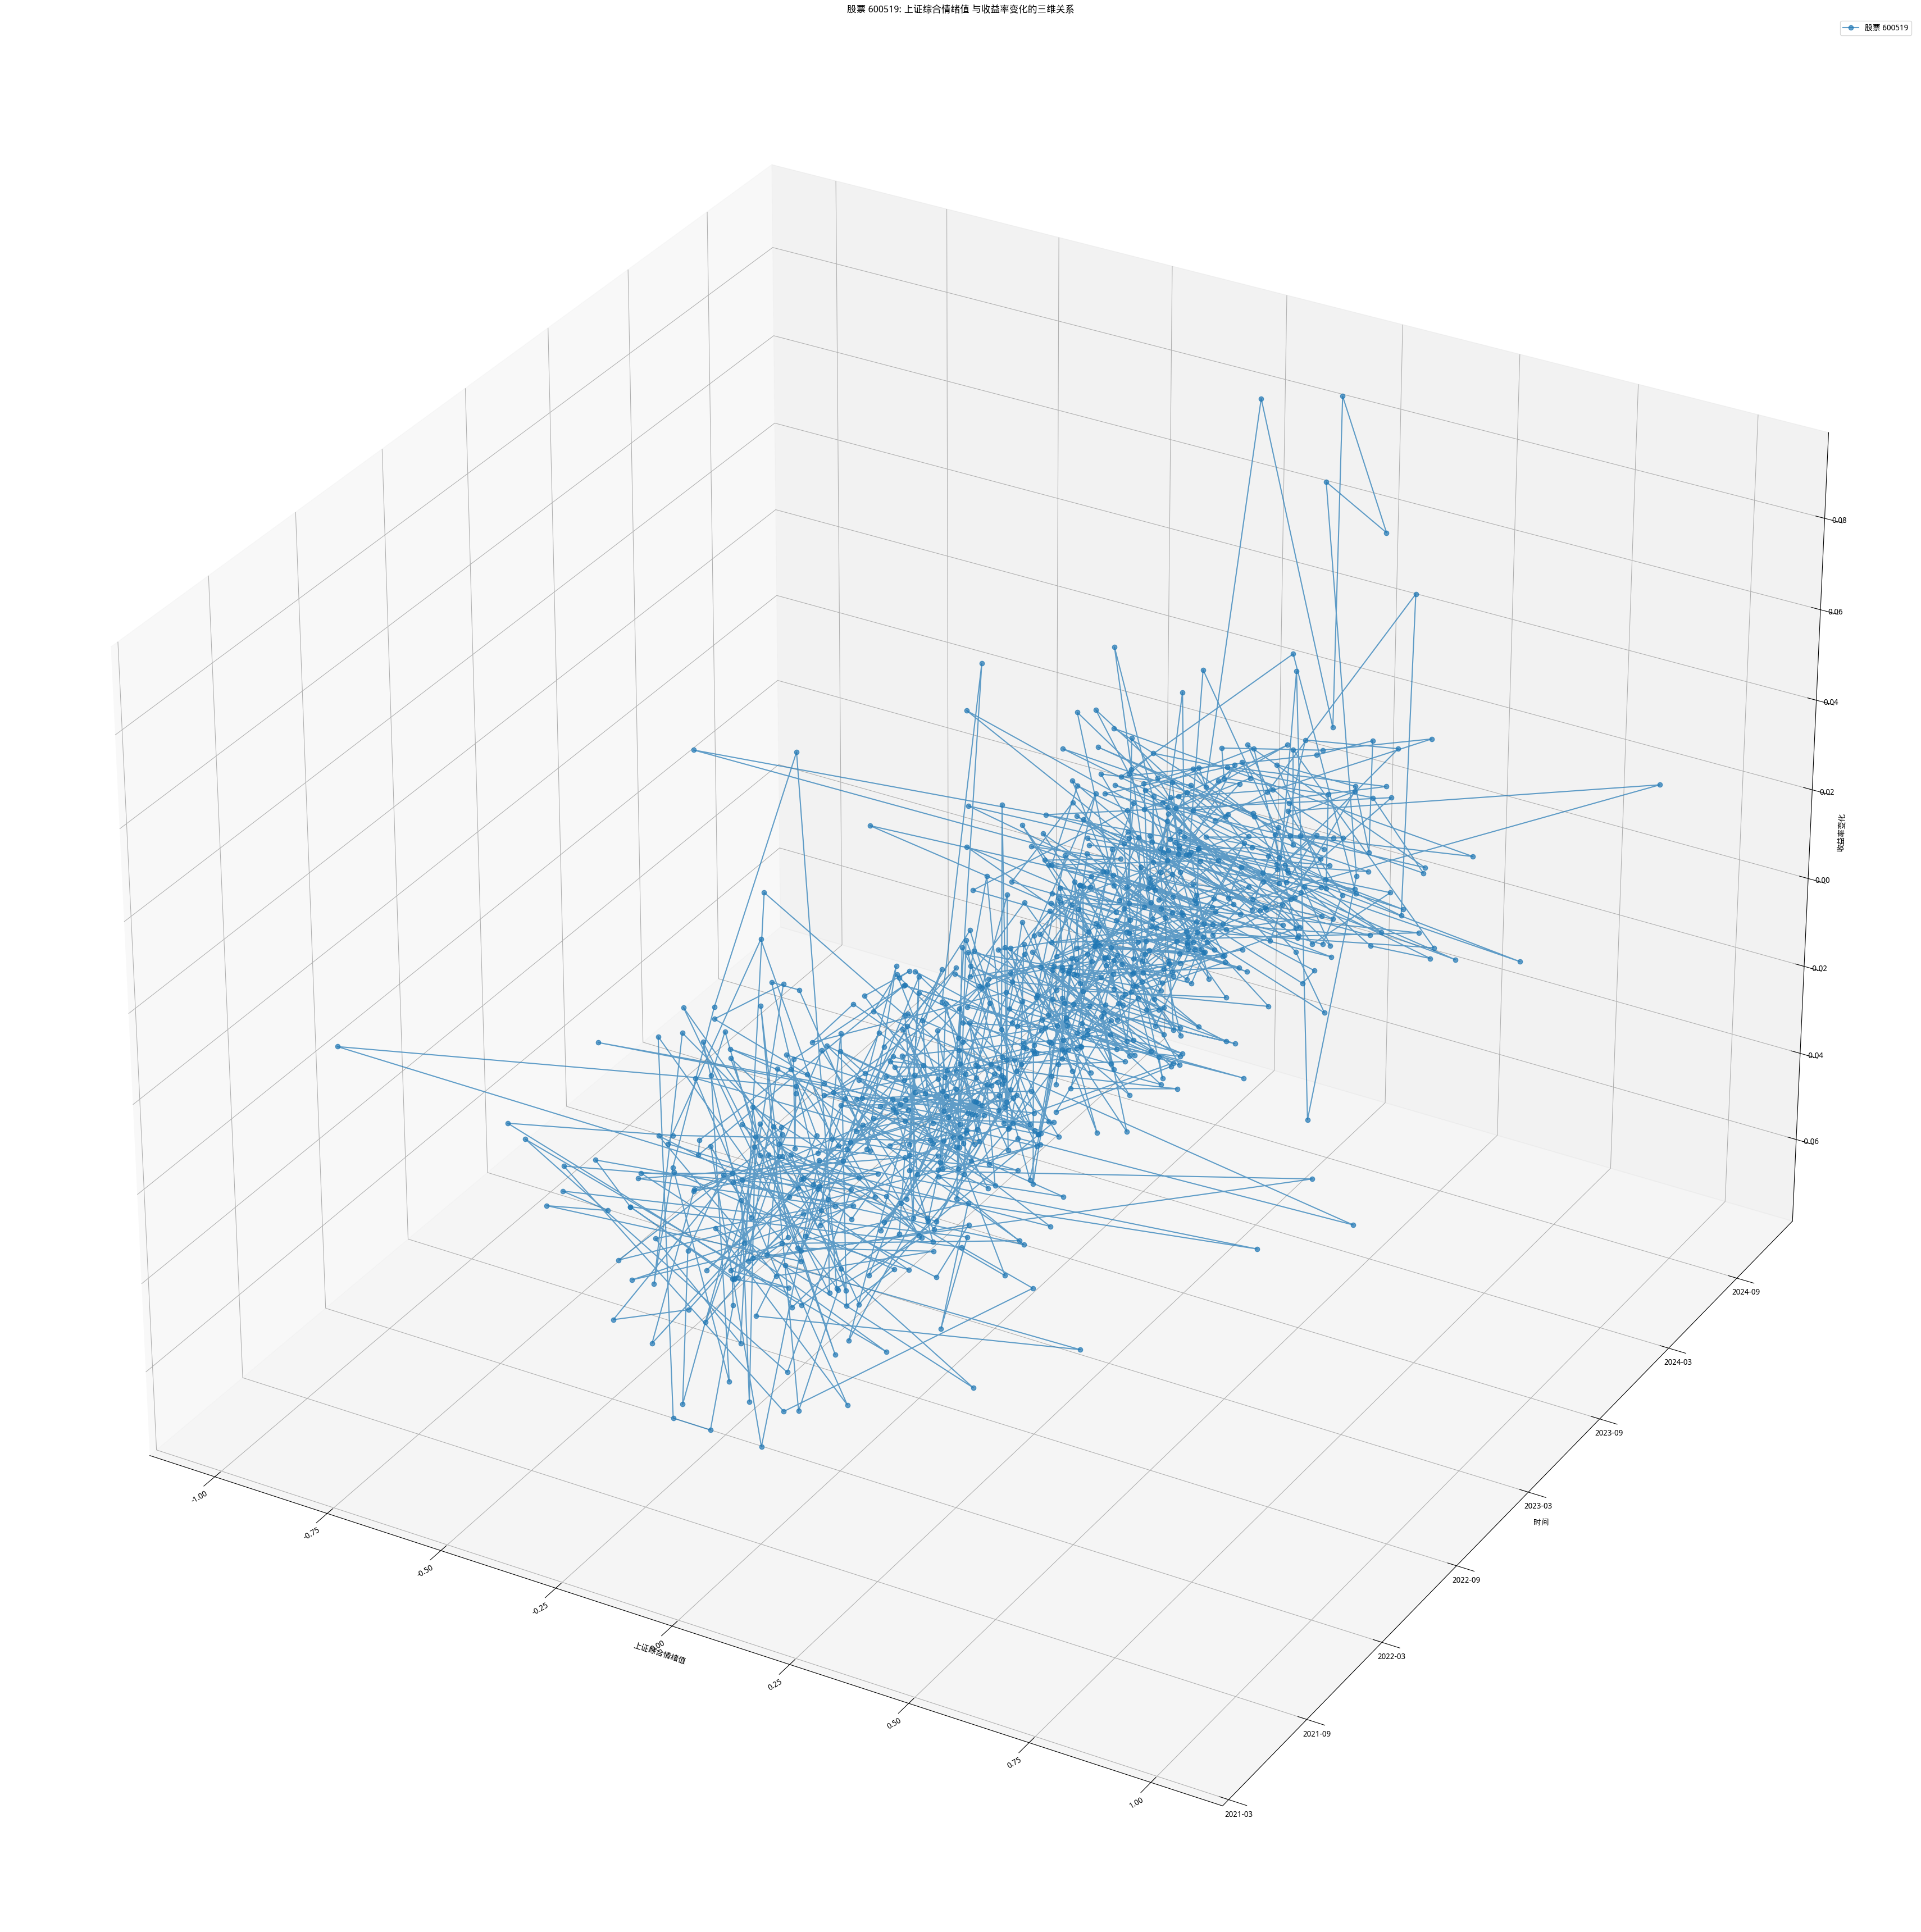

In [53]:
### 聚类2示例 ###
if MODEL != 'Deep-learning/Ours':
    # 复制数据集，确保不会修改原始数据
    merged_data_cleaned = final_data.copy()
    merged_data_cleaned['日期'] = pd.to_datetime(merged_data_cleaned['日期'])
    
    # 选择聚类标签为 0 的数据，找到数据最多的股票编号
    cluster_0_data = merged_data_cleaned[merged_data_cleaned['聚类标签'] == 2]
    top_stock_code = cluster_0_data['股票编号'].value_counts().idxmax()
    top_stock_data = cluster_0_data[cluster_0_data['股票编号'] == top_stock_code]
    
    
    # 创建 3D 图
    fig = plt.figure(figsize=(50, 50))
    ax = fig.add_subplot(111, projection='3d')
    
    # 提取绘图数据
    x = top_stock_data[EMO_NAME]  # 情绪值作为 x 轴
    y = mdates.date2num(top_stock_data['日期'])  # 时间转换为数值类型
    z = top_stock_data['收益率变化']  # 收益率变化作为 z 轴
    
    # 绘制三维折线图
    ax.plot(x, y, z, label=f"股票 {top_stock_code}", marker='o', linestyle='-', alpha=0.7)
    
    # 设置轴标签
    ax.set_xlabel(EMO_NAME)
    ax.set_ylabel('时间')
    ax.set_zlabel('收益率变化')
    ax.set_title(f'股票 {top_stock_code}: {EMO_NAME} 与收益率变化的三维关系')
    
    # 设置 y 轴时间刻度（每半年一个刻度）
    ax.yaxis.set_major_locator(mdates.MonthLocator(bymonthday=15, interval=6))  # 每半年一个刻度
    ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 按年月显示
    
    # 旋转日期标签防止重叠
    fig.autofmt_xdate()
    
    # 调整布局并保存图像
    plt.legend()
    # plt.savefig(f'个股分析/{market_address}/图片/聚类2_{top_stock_code}.png', dpi=300, bbox_inches='tight')
    plt.show()


## 进行聚类间实证分析

#### 读取个股金融数据

In [54]:
# 读取原始数据
microfinancial_data = pd.read_csv(f'{Financial_Data_PATH}/个股微观金融数据.csv', encoding='utf-8')

# 选择重要的列，日期和股票代码一定要包含
columns_to_select = [
    '日期_Date',  # 日期
    '股票代码_Stkcd',  # 股票代码
    '日振幅(%)_Dampltd',  # 日振幅
    '日收益率_Dret',  # 日收益率
    '市盈率_PE',  # 市盈率
    '成交量_Trdvol',  # 成交量
    '流通股日换手率(%)_DTrdTurnR',
    '总市值加权平均日资本收益_Daretmc',
]

# 提取相关列
microfinancial_data = microfinancial_data[columns_to_select]
microfinancial_data['股票代码_Stkcd'] = microfinancial_data['股票代码_Stkcd'].apply(lambda x: str(x).zfill(6))

# microfinancial_data = microfinancial_data[microfinancial_data['日期_Date'] == '2022-03-01'] #用于检验某一天数据
microfinancial_data

日期_Date 股票代码_Stkcd  日振幅(%)_Dampltd  日收益率_Dret  市盈率_PE   成交量_Trdvol  \
0       2023-02-01     000100          1.6667     0.0071  276.47  147751077.0   
1       2023-02-02     000100          2.1277    -0.0095  273.86  188929965.0   
2       2023-02-03     000100          2.1480    -0.0048  272.55  200087013.0   
3       2023-02-06     000100          1.6787    -0.0072  270.59  134158688.0   
4       2023-02-07     000100          1.4493     0.0024  271.24   87200030.0   
...            ...        ...             ...        ...     ...          ...   
162617  2024-11-14     601566          3.0340    -0.0255   16.94    3223500.0   
162618  2024-11-15     601566          2.8643     0.0025   16.98    2824500.0   
162619  2024-11-18     601566          3.8509    -0.0025   16.94    3729993.0   
162620  2024-11-19     601566          2.3661     0.0137   17.17    3367065.0   
162621  2024-11-20     601566          2.4570     0.0172   17.46    4148800.0   

        流通股日换手率(%)_DTrdTurnR  总市值加权平均日资本收益_Daretmc  
0                     1.0357                0.0145  
1                     1.3244               -0.0005  
2                     1.4026               -0.0042  
3                     0.9404               -0.0084  
4                     0.6113                0.0036  
...                      ...                   ...  
162617                0.5610               -0.0146  
162618                0.4915               -0.0112  
162619                0.6491                0.0009  
162620                0.5859                0.0031  
162621                0.7220                0.0054  

[162622 rows x 8 columns]

#### 加载之前的情绪聚类数据

In [55]:
final_data

日期    股票编号   上证综合情绪值  沪深300情绪值    创业板情绪值          交易量     收益率变化  \
0     2021-06-01  000002 -0.250000 -0.250000 -0.250000   60990961.0 -0.003745   
1     2021-06-08  000002  0.000000  0.000000  0.000000   44676494.0  0.004626   
2     2021-06-10  000002 -0.311111 -0.311111 -0.311111   53800776.0 -0.010035   
3     2021-06-11  000002 -0.333333 -0.333333 -0.333333   75853738.0 -0.014035   
4     2021-06-15  000002 -1.000000 -1.000000 -1.000000   89915501.0 -0.020957   
...          ...     ...       ...       ...       ...          ...       ...   
85668 2024-11-11  688981  0.666667  0.666667  0.666667  138069018.0  0.046660   
85669 2024-11-12  688981  0.111111  0.111111  0.111111  108866759.0 -0.036864   
85670 2024-11-13  688981  0.300000  0.300000  0.300000   80759477.0 -0.019484   
85671 2024-11-14  688981  0.400000  0.400000  0.400000   76194102.0 -0.022897   
85672 2024-11-15  688981  0.250000  0.250000  0.250000   71066743.0 -0.020233   

       聚类标签  公司名称  
0         2   万科A  
1         2   万科A  
2         2   万科A  
3         2   万科A  
4         2   万科A  
...     ...   ...  
85668     2  中芯国际  
85669     2  中芯国际  
85670     2  中芯国际  
85671     2  中芯国际  
85672     2  中芯国际  

[85673 rows x 9 columns]

#### 读取市场换手率与市盈率并进行插值

In [56]:
turnover_PE_rate = pd.read_csv(f'{Financial_Data_PATH}/市场整体换手率与市盈率.csv', encoding='utf-8')
turnover_PE_rate['统计日期'] = pd.to_datetime(turnover_PE_rate['统计日期'])

# 按照 '统计日期' 排序
turnover_PE_rate = turnover_PE_rate.sort_values(by='统计日期')

# 对 '平均市盈率' 和 '换手率(总股本)' 进行线性插值
turnover_PE_rate[['平均市盈率', '换手率(总股本)']] = turnover_PE_rate[['平均市盈率', '换手率(总股本)']].interpolate(method='linear', axis=0)

turnover_PE_rate = turnover_PE_rate.drop(columns=['统计口径编码'])
turnover_PE_rate.columns = ['统计日期', '市场平均市盈率', '市场换手率(总股本)']
turnover_PE_rate

统计日期    市场平均市盈率  市场换手率(总股本)
0     2021-01-04  16.918000    1.140600
12    2021-01-04  25.986305    1.237217
11    2021-01-04  35.054611    1.333834
10    2021-01-04  44.122916    1.430451
8     2021-01-04  53.191221    1.527068
...          ...        ...         ...
12364 2024-12-06  39.185061    2.176139
12363 2024-12-06  14.390000    1.292500
12374 2024-12-06  14.390000    1.292500
12368 2024-12-06  14.390000    1.292500
12375 2024-12-06  14.390000    1.292500

[12376 rows x 3 columns]

#### 数据拼接

In [57]:
# 将日期列转换为 datetime 格式
final_data['日期'] = pd.to_datetime(final_data['日期'])
microfinancial_data['日期_Date'] = pd.to_datetime(microfinancial_data['日期_Date'], errors='coerce')

# 使用 merge 进行内连接
result = pd.merge(
    final_data, 
    microfinancial_data, 
    left_on=['日期', '股票编号'],  # 左表的 key
    right_on=['日期_Date', '股票代码_Stkcd'], # 右表的 key
    how='inner'                   # 内连接
)

result = pd.merge(
    result, 
    turnover_PE_rate, 
    left_on=['日期'],  # 左表的 key
    right_on=['统计日期'], # 右表的 key
    how='inner'                   # 内连接
)

# 删除重复的列
result = result.drop(columns=['日期_Date', '股票代码_Stkcd', '交易量', '日收益率_Dret', '统计日期'])

# 修改列的位置，更加美观可视
columns_to_move = ['聚类标签', '公司名称']
result = pd.concat([result.drop(columns=columns_to_move), result[columns_to_move]], axis=1)

# 将成交量除以10000，并以万计数
result['成交量(百万)_Trdvol'] = result['成交量_Trdvol'] / 1_000_000
result = result.drop(columns=['成交量_Trdvol'])

cols_to_check = ['收益率变化', '日振幅(%)_Dampltd', '市盈率_PE', 
                 '成交量(百万)_Trdvol', '流通股日换手率(%)_DTrdTurnR']

# 删除含有空值的行
result = result.dropna(subset=cols_to_check)
result

日期    股票编号   上证综合情绪值  沪深300情绪值    创业板情绪值     收益率变化  \
0       2021-06-01  000002 -0.250000 -0.250000 -0.250000 -0.003745   
1       2021-06-01  000002 -0.250000 -0.250000 -0.250000 -0.003745   
2       2021-06-01  000002 -0.250000 -0.250000 -0.250000 -0.003745   
3       2021-06-01  000002 -0.250000 -0.250000 -0.250000 -0.003745   
4       2021-06-01  000002 -0.250000 -0.250000 -0.250000 -0.003745   
...            ...     ...       ...       ...       ...       ...   
1150274 2024-11-15  603986  0.333333  0.333333  0.333333 -0.028519   
1150275 2024-11-15  603986  0.333333  0.333333  0.333333 -0.028519   
1150276 2024-11-15  603986  0.333333  0.333333  0.333333 -0.028519   
1150277 2024-11-15  603986  0.333333  0.333333  0.333333 -0.028519   
1150278 2024-11-15  603986  0.333333  0.333333  0.333333 -0.028519   

         日振幅(%)_Dampltd  市盈率_PE  流通股日换手率(%)_DTrdTurnR  总市值加权平均日资本收益_Daretmc  \
0                1.8727    7.44                0.6272                0.0039   
1                1.8727    7.44                0.6272                0.0039   
2                1.8727    7.44                0.6272                0.0039   
3                1.8727    7.44                0.6272                0.0039   
4                1.8727    7.44                0.6272                0.0039   
...                 ...     ...                   ...                   ...   
1150274          5.5086  157.60                3.1891               -0.0112   
1150275          5.5086  157.60                3.1891               -0.0112   
1150276          5.5086  157.60                3.1891               -0.0112   
1150277          5.5086  157.60                3.1891               -0.0112   
1150278          5.5086  157.60                3.1891               -0.0112   

           市场平均市盈率  市场换手率(总股本)  聚类标签  公司名称  成交量(百万)_Trdvol  
0        24.523860    1.030223     2   万科A       60.990961  
1        31.761720    1.132746     2   万科A       60.990961  
2        38.999580    1.235269     2   万科A       60.990961  
3        46.237440    1.337792     2   万科A       60.990961  
4        53.475301    1.440316     2   万科A       60.990961  
...            ...         ...   ...   ...             ...  
1150274  65.934994    2.786785     2  兆易创新       21.198816  
1150275  48.663329    2.336790     2  兆易创新       21.198816  
1150276  31.391665    1.886795     2  兆易创新       21.198816  
1150277  14.120000    1.436800     2  兆易创新       21.198816  
1150278  20.714063    3.481729     2  兆易创新       21.198816  

[1150175 rows x 15 columns]

In [58]:
# 查看匹配的公司数
unique_stock_count = result['股票编号'].nunique()
print(unique_stock_count)

179


#### 回归检验

In [59]:
## 单因子：总市值加权平均日资本收益回归检验
df = result.copy()

# 自变量是总市值加权平均日资本收益
X = df[['总市值加权平均日资本收益_Daretmc']]

# 要拟合的因变量列表
y_vars = [
    '收益率变化', '日振幅(%)_Dampltd', '市盈率_PE', 
    '成交量(百万)_Trdvol','流通股日换手率(%)_DTrdTurnR'
]


# 添加常数项（截距项）
X_with_const = sm.add_constant(X)

# 创建一个空的列表存储回归结果
regression_results = []

# 对每个因变量进行回归分析
for y_var in y_vars:
    y = df[y_var]  # 当前的因变量

    # 对股票编号分组进行回归
    grouped = df.groupby('股票编号')
    
    r_squared_list = []
    
    for stock_code, group in grouped:
        X_group = group[['总市值加权平均日资本收益_Daretmc']]
        X_with_const_group = sm.add_constant(X_group)
        y_group = group[y_var]
        
        try:
            # 拟合回归模型
            model = sm.OLS(y_group, X_with_const_group)
            results = model.fit()

            # 提取回归R方
            r_squared_list.append(results.rsquared)
        except Exception as e:
            # 如果回归失败（如R方计算为-inf），跳过
            print(f"回归失败：股票编号 {stock_code}, 错误信息: {e}")
            r_squared_list.append(float('nan'))  # 将其R方设为NaN
    
    # 计算R方的平均值，忽略NaN值
    avg_r_squared = pd.Series(r_squared_list).mean()
    
    # 对于每个因变量，存储回归系数等信息
    model = sm.OLS(y, X_with_const)
    results = model.fit()

    regression_results.append({
        'Variable': y_var,
        'S': round(results.bse['总市值加权平均日资本收益_Daretmc'], 3),  # 标准误差
        'Econ': round(results.params['总市值加权平均日资本收益_Daretmc'], 3),  # 回归系数
        'Constant': round(results.params['const'], 3),  # 截距项，保留三位小数
        'R_squared': round(results.rsquared * 100, 3), # 总体的回归R方，保留三位小数
        'Econ_t_value': round(results.tvalues['总市值加权平均日资本收益_Daretmc'], 3),  # Econ的t统计量，保留三位小数
        'Constant_t_value': round(results.tvalues['const'], 3)  # Constant的t统计量，保留三位小数
    })

# 转换为 DataFrame
regression_df = pd.DataFrame(regression_results)
# regression_df.to_csv(f'个股分析/{market_address}/双因子回归结果/单因子：总市值加权平均日资本收益.csv')
regression_df


Variable       S     Econ  Constant  R_squared  Econ_t_value  \
0                 收益率变化   0.002    1.061     0.001     22.451       577.047   
1        日振幅(%)_Dampltd   0.170   10.871     3.323      0.354        63.906   
2                市盈率_PE  11.726   26.180    28.859      0.000         2.233   
3        成交量(百万)_Trdvol   9.043  411.849    73.128      0.180        45.545   
4  流通股日换手率(%)_DTrdTurnR   0.141    5.882     1.310      0.151        41.720   

   Constant_t_value  
0            24.775  
1          1628.273  
2           205.130  
3           674.012  
4           774.486

In [60]:
## 单因子：情绪回归检验
if MODEL != 'Deep-learning/Ours':
    df = result.copy()
    
    # 自变量是情绪值
    X = df[[EMO_NAME]]
    
    # 要拟合的因变量列表
    y_vars = [
        '收益率变化', '日振幅(%)_Dampltd', '市盈率_PE', 
        '成交量(百万)_Trdvol','流通股日换手率(%)_DTrdTurnR'
    ]
    
    # 添加常数项（截距项）
    X_with_const = sm.add_constant(X)
    
    # 创建一个空的列表存储回归结果
    regression_results = []
    
    # 对每个因变量进行回归分析
    for y_var in y_vars:
        y = df[y_var]  # 当前的因变量
    
        # 对股票编号分组进行回归
        grouped = df.groupby('股票编号')
        
        for stock_code, group in grouped:
            X_group = group[[EMO_NAME]]
            X_with_const_group = sm.add_constant(X_group)
            y_group = group[y_var]
            
            # 拟合回归模型
            model = sm.OLS(y_group, X_with_const_group)
            results = model.fit()
    
            # 提取回归R方
            r_squared_list.append(results.rsquared)
        
        # 计算R方的平均值
        avg_r_squared = sum(r_squared_list) / len(r_squared_list)
        
        # 对于每个因变量，存储回归系数等信息
        model = sm.OLS(y, X_with_const)
        results = model.fit()
    
        regression_results.append({
            'Variable': y_var,
            'S': round(results.bse[EMO_NAME], 3),  # 标准误差，保留三位小数
            'Econ': round(results.params[EMO_NAME], 3),  # 回归系数，保留三位小数
            'Constant': round(results.params['const'], 3),  # 截距项，保留三位小数
            'R_squared': round(results.rsquared * 100, 3), # 总体的回归R方，保留三位小数
            'Econ_t_value': round(results.tvalues[EMO_NAME], 3),  # Econ的t统计量，保留三位小数
            'Constant_t_value': round(results.tvalues['const'], 3)  # Constant的t统计量，保留三位小数
        })
else:
    df = result.copy()
    
    # 拆分高维情绪变量为多个列（多变量）
    emo_array = np.array(df['高维情绪变量'].tolist())  # shape: (样本数, 维度)
    emo_df = pd.DataFrame(emo_array, columns=[f'emotion_{i}' for i in range(emo_array.shape[1])])
    
    # 合并回df
    df = pd.concat([df.reset_index(drop=True), emo_df], axis=1)
    
    # 构造多维自变量X
    EMO_COLUMNS = [f'emotion_{i}' for i in range(emo_array.shape[1])]
    X = df[EMO_COLUMNS]
    
    # 要拟合的因变量列表
    y_vars = [
        '收益率变化', '日振幅(%)_Dampltd', '市盈率_PE', 
        '成交量(百万)_Trdvol','流通股日换手率(%)_DTrdTurnR'
    ]
    
    # 添加常数项（截距项）
    X_with_const = sm.add_constant(X)
    
    regression_results = []

    for y_var in y_vars:
        y = df[y_var]
        
        # 每个股票编号做回归，统计 R²
        grouped = df.groupby('股票编号')
        
        # 全部数据回归
        model = sm.OLS(y, X_with_const)
        results = model.fit()

        # 提取部分指标（示例提取第一个变量的参数）
        econ_param = results.params[EMO_COLUMNS[0]]
        econ_bse = results.bse[EMO_COLUMNS[0]]
        econ_t = results.tvalues[EMO_COLUMNS[0]]
        
        regression_results.append({
            'Variable': y_var,
            'S': round(econ_bse, 3),
            'Econ': round(econ_param, 3),
            'Constant': round(results.params['const'], 3),
            'R_squared_global': round(results.rsquared * 100, 3),
            'Econ_t_value': round(econ_t, 3),
            'Constant_t_value': round(results.tvalues['const'], 3)
        })
    


# 转换为 DataFrame
regression_df = pd.DataFrame(regression_results)
# regression_df.to_csv(f'个股分析/{market_address}/双因子回归结果/单因子：{EMO_NAME}.csv')
regression_df


Variable      S   Econ  Constant  R_squared  Econ_t_value  \
0                 收益率变化  0.000  0.003    -0.000      0.386        66.751   
1        日振幅(%)_Dampltd  0.004 -0.031     3.329      0.005        -7.584   
2                市盈率_PE  0.281  1.409    28.616      0.002         5.018   
3        成交量(百万)_Trdvol  0.217 -3.750    73.776      0.026       -17.304   
4  流通股日换手率(%)_DTrdTurnR  0.003 -0.011     1.312      0.001        -3.128   

   Constant_t_value  
0            -1.041  
1          1539.253  
2           192.309  
3           642.399  
4           732.717

In [61]:
## 总体双因子回归检验
if MODEL != 'Deep-learning/Ours':
    df = result.copy()
    
    # 自变量是情绪值和总市值加权平均日资本收益
    X = df[[EMO_NAME, '总市值加权平均日资本收益_Daretmc']]
    
    # 要拟合的因变量列表
    y_vars = [
        '收益率变化', '日振幅(%)_Dampltd', '市盈率_PE', 
        '成交量(百万)_Trdvol','流通股日换手率(%)_DTrdTurnR'
    ]
    
    # 添加常数项（截距项）
    X_with_const = sm.add_constant(X)
    
    # 创建一个空的列表存储回归结果
    regression_results = []
    
    # 对每个因变量进行回归分析
    for y_var in y_vars:
        y = df[y_var]  # 当前的因变量
    
        # 对股票编号分组进行回归
        grouped = df.groupby('股票编号')
   
        # 对于每个因变量，存储回归系数等信息
        model = sm.OLS(y, X_with_const)
        results = model.fit()
    
        regression_results.append({
            'Variable': y_var,
            'S': round(results.bse[EMO_NAME], 3),  # 标准误差，保留三位小数
            'Econ': round(results.params[EMO_NAME], 3),  # 回归系数，保留三位小数
            'Constant': round(results.params['const'], 3),  # 截距项，保留三位小数
            'R_squared': round(results.rsquared * 100, 3), # 总体的回归R方，保留三位小数
            'Econ_t_value': round(results.tvalues[EMO_NAME], 3),  # Econ的t统计量，保留三位小数
            'Constant_t_value': round(results.tvalues['const'], 3)  # Constant的t统计量，保留三位小数
        })

else:
    df = result.copy()
    
    # 拆分高维情绪变量为多个列（多变量）
    emo_array = np.array(df['高维情绪变量'].tolist())  # shape: (样本数, 维度)
    emo_df = pd.DataFrame(emo_array, columns=[f'emotion_{i}' for i in range(emo_array.shape[1])])
    
    # 合并回df
    df = pd.concat([df.reset_index(drop=True), emo_df], axis=1)
    
    # 构造多维自变量X
    EMO_COLUMNS = [f'emotion_{i}' for i in range(emo_array.shape[1])]
    X = df[['总市值加权平均日资本收益_Daretmc'] + EMO_COLUMNS]
    
    # 要拟合的因变量列表
    y_vars = [
        '收益率变化', '日振幅(%)_Dampltd', '市盈率_PE', 
        '成交量(百万)_Trdvol','流通股日换手率(%)_DTrdTurnR'
    ]
    
    # 添加常数项（截距项）
    X_with_const = sm.add_constant(X)
    
    regression_results = []

    for y_var in y_vars:
        y = df[y_var]
        
        # 每个股票编号做回归，统计 R²
        grouped = df.groupby('股票编号')

        # 全部数据回归
        model = sm.OLS(y, X_with_const)
        results = model.fit()

        # 提取部分指标（示例提取第一个变量的参数）
        econ_param = results.params[EMO_COLUMNS[0]]
        econ_bse = results.bse[EMO_COLUMNS[0]]
        econ_t = results.tvalues[EMO_COLUMNS[0]]
        
        regression_results.append({
            'Variable': y_var,
            'S': round(econ_bse, 3),
            'Econ': round(econ_param, 3),
            'Constant': round(results.params['const'], 3),
            'R_squared': round(results.rsquared * 100, 3),
            'Econ_t_value': round(econ_t, 3),
            'Constant_t_value': round(results.tvalues['const'], 3)
        })
    

# 转换为 DataFrame
regression_df = pd.DataFrame(regression_results)
# regression_df.to_csv(f'个股分析/{market_address}/双因子回归结果/双因子：总体分析.csv')
regression_df


Variable      S   Econ  Constant  R_squared  Econ_t_value  \
0                 收益率变化  0.000  0.002     0.000     22.648        54.125   
1        日振幅(%)_Dampltd  0.004 -0.041     3.331      0.362       -10.000   
2                市盈率_PE  0.281  1.388    28.620      0.003         4.938   
3        成交量(百万)_Trdvol  0.217 -4.126    73.840      0.211       -19.041   
4  流通股日换手率(%)_DTrdTurnR  0.003 -0.016     1.313      0.153        -4.698   

   Constant_t_value  
0             5.810  
1          1542.678  
2           192.320  
3           643.510  
4           733.729

In [62]:
## 聚类0的回归检验
if MODEL != 'Deep-learning/Ours':
    df = result[result['聚类标签'] == 0].copy()
    
    # 自变量是情绪值和总市值加权平均日资本收益
    X = df[[EMO_NAME, '总市值加权平均日资本收益_Daretmc']]
    
    # 要拟合的因变量列表
    y_vars = [
        '收益率变化', '日振幅(%)_Dampltd', '市盈率_PE', 
        '成交量(百万)_Trdvol','流通股日换手率(%)_DTrdTurnR'
    ]
    
    
    # 添加常数项（截距项）
    X_with_const = sm.add_constant(X)
    
    # 创建一个空的列表存储回归结果
    regression_results = []
    
    # 对每个因变量进行回归分析
    for y_var in y_vars:
        y = df[y_var]  # 当前的因变量
    
        # 对股票编号分组进行回归
        grouped = df.groupby('股票编号')
        
        # 对于每个因变量，存储回归系数等信息
        model = sm.OLS(y, X_with_const)
        results = model.fit()
    
        regression_results.append({
            'Variable': y_var,
            'S': round(results.bse[EMO_NAME], 3),  # 标准误差，保留三位小数
            'Econ': round(results.params[EMO_NAME], 3),  # 回归系数，保留三位小数
            'Constant': round(results.params['const'], 3),  # 截距项，保留三位小数
            'R_squared': round(results.rsquared * 100, 3), # 总体的回归R方，保留三位小数
            'Econ_t_value': round(results.tvalues[EMO_NAME], 3),  # Econ的t统计量，保留三位小数
            'Constant_t_value': round(results.tvalues['const'], 3)  # Constant的t统计量，保留三位小数
        })

else:
    df = result[result['聚类标签'] == 0].copy()

    # 拆分高维情绪变量为多个列（多变量）
    emo_array = np.array(df['高维情绪变量'].tolist())  # shape: (样本数, 维度)
    emo_df = pd.DataFrame(emo_array, columns=[f'emotion_{i}' for i in range(emo_array.shape[1])])
    
    # 合并回df
    df = pd.concat([df.reset_index(drop=True), emo_df], axis=1)
    
    # 构造多维自变量X
    EMO_COLUMNS = [f'emotion_{i}' for i in range(emo_array.shape[1])]
    X = df[['总市值加权平均日资本收益_Daretmc'] + EMO_COLUMNS]
    
    # 要拟合的因变量列表
    y_vars = [
        '收益率变化', '日振幅(%)_Dampltd', '市盈率_PE', 
        '成交量(百万)_Trdvol','流通股日换手率(%)_DTrdTurnR'
    ]
    
    # 添加常数项（截距项）
    X_with_const = sm.add_constant(X)
    
    regression_results = []

    for y_var in y_vars:
        y = df[y_var]
        
        # 每个股票编号做回归，统计 R²
        grouped = df.groupby('股票编号')
        
        # 全部数据回归
        model = sm.OLS(y, X_with_const)
        results = model.fit()

        # 提取部分指标（示例提取第一个变量的参数）
        econ_param = results.params[EMO_COLUMNS[0]]
        econ_bse = results.bse[EMO_COLUMNS[0]]
        econ_t = results.tvalues[EMO_COLUMNS[0]]
        
        regression_results.append({
            'Variable': y_var,
            'S': round(econ_bse, 3),
            'Econ': round(econ_param, 3),
            'Constant': round(results.params['const'], 3),
            'R_squared': round(results.rsquared * 100, 3),
            'Econ_t_value': round(econ_t, 3),
            'Constant_t_value': round(results.tvalues['const'], 3)
        })
    
# 转换为 DataFrame
regression_df = pd.DataFrame(regression_results)
# regression_df.to_csv(f'个股分析/{market_address}/双因子回归结果/双因子：聚类0检验.csv')
regression_df


Variable      S   Econ  Constant  R_squared  Econ_t_value  \
0                 收益率变化  0.000  0.002     0.000     22.319        28.754   
1        日振幅(%)_Dampltd  0.006 -0.050     3.314      0.483        -7.819   
2                市盈率_PE  0.447  2.719    31.532      0.009         6.080   
3        成交量(百万)_Trdvol  0.321 -4.519    69.119      0.245       -14.084   
4  流通股日换手率(%)_DTrdTurnR  0.005 -0.021     1.220      0.140        -4.055   

   Constant_t_value  
0             4.109  
1           906.575  
2           123.260  
3           376.609  
4           407.873

In [63]:
## 聚类1的回归检验
if MODEL != 'Deep-learning/Ours':
    df = result[result['聚类标签'] == 1].copy()
    
    # 自变量是情绪值和总市值加权平均日资本收益
    X = df[[EMO_NAME, '总市值加权平均日资本收益_Daretmc']]
    
    # 要拟合的因变量列表
    y_vars = [
        '收益率变化', '日振幅(%)_Dampltd', '市盈率_PE', 
        '成交量(百万)_Trdvol','流通股日换手率(%)_DTrdTurnR'
    ]
    
    
    # 添加常数项（截距项）
    X_with_const = sm.add_constant(X)
    
    # 创建一个空的列表存储回归结果
    regression_results = []
    
    # 对每个因变量进行回归分析
    for y_var in y_vars:
        y = df[y_var]  # 当前的因变量
    
        # 对股票编号分组进行回归
        grouped = df.groupby('股票编号')

        # 对于每个因变量，存储回归系数等信息
        model = sm.OLS(y, X_with_const)
        results = model.fit()
    
        regression_results.append({
            'Variable': y_var,
            'S': round(results.bse[EMO_NAME], 3),  # 标准误差，保留三位小数
            'Econ': round(results.params[EMO_NAME], 3),  # 回归系数，保留三位小数
            'Constant': round(results.params['const'], 3),  # 截距项，保留三位小数
            'R_squared': round(results.rsquared * 100, 3), # 总体的回归R方，保留三位小数
            'Econ_t_value': round(results.tvalues[EMO_NAME], 3),  # Econ的t统计量，保留三位小数
            'Constant_t_value': round(results.tvalues['const'], 3)  # Constant的t统计量，保留三位小数
        })
else:
    df = result[result['聚类标签'] == 1].copy()
    
    # 拆分高维情绪变量为多个列（多变量）
    emo_array = np.array(df['高维情绪变量'].tolist())  # shape: (样本数, 维度)
    print('(样本数, 维度):', emo_array.shape)
    emo_df = pd.DataFrame(emo_array, columns=[f'emotion_{i}' for i in range(emo_array.shape[1])])
    
    # 合并回df
    df = pd.concat([df.reset_index(drop=True), emo_df], axis=1)
    
    # 构造多维自变量X
    EMO_COLUMNS = [f'emotion_{i}' for i in range(emo_array.shape[1])]
    X = df[['总市值加权平均日资本收益_Daretmc'] + EMO_COLUMNS]
    
    # 要拟合的因变量列表
    y_vars = [
        '收益率变化', '日振幅(%)_Dampltd', '市盈率_PE', 
        '成交量(百万)_Trdvol','流通股日换手率(%)_DTrdTurnR'
    ]
    
    # 添加常数项（截距项）
    X_with_const = sm.add_constant(X)
    
    regression_results = []

    for y_var in y_vars:
        y = df[y_var]
        
        # 每个股票编号做回归，统计 R²
        grouped = df.groupby('股票编号')    

        # 全部数据回归
        model = sm.OLS(y, X_with_const)
        results = model.fit()

        # 提取部分指标（示例提取第一个变量的参数）
        econ_param = results.params[EMO_COLUMNS[0]]
        econ_bse = results.bse[EMO_COLUMNS[0]]
        econ_t = results.tvalues[EMO_COLUMNS[0]]
        
        regression_results.append({
            'Variable': y_var,
            'S': round(econ_bse, 3),
            'Econ': round(econ_param, 3),
            'Constant': round(results.params['const'], 3),
            'R_squared': round(results.rsquared * 100, 3),
            'Econ_t_value': round(econ_t, 3),
            'Constant_t_value': round(results.tvalues['const'], 3)
        })

# 转换为 DataFrame
regression_df = pd.DataFrame(regression_results)
# regression_df.to_csv(f'个股分析/{market_address}/双因子回归结果/双因子：聚类1检验.csv')
regression_df


Variable      S   Econ  Constant  R_squared  Econ_t_value  \
0                 收益率变化  0.000  0.002     0.001     18.784        15.676   
1        日振幅(%)_Dampltd  0.009 -0.022     3.387      0.461        -2.408   
2                市盈率_PE  0.990  0.028    13.060      0.000         0.028   
3        成交量(百万)_Trdvol  0.208 -1.715    38.431      0.287        -8.247   
4  流通股日换手率(%)_DTrdTurnR  0.007 -0.043     1.264      0.165        -5.815   

   Constant_t_value  
0            16.412  
1           607.811  
2            21.630  
3           302.915  
4           282.576

In [64]:
## 聚类2的回归检验
if MODEL != 'Deep-learning/Ours':
    df = result[result['聚类标签'] == 2].copy()
    
    # 自变量是情绪值和总市值加权平均日资本收益
    X = df[[EMO_NAME, '总市值加权平均日资本收益_Daretmc']]
    
    # 要拟合的因变量列表
    y_vars = [
        '收益率变化', '日振幅(%)_Dampltd', '市盈率_PE', 
        '成交量(百万)_Trdvol','流通股日换手率(%)_DTrdTurnR'
    ]
    
    
    # 添加常数项（截距项）
    X_with_const = sm.add_constant(X)
    
    # 创建一个空的列表存储回归结果
    regression_results = []
    
    # 对每个因变量进行回归分析
    for y_var in y_vars:
        y = df[y_var]  # 当前的因变量
    
        # 对股票编号分组进行回归
        grouped = df.groupby('股票编号')
    
        # 对于每个因变量，存储回归系数等信息
        model = sm.OLS(y, X_with_const)
        results = model.fit()
    
        regression_results.append({
            'Variable': y_var,
            'S': round(results.bse[EMO_NAME], 3),  # 标准误差，保留三位小数
            'Econ': round(results.params[EMO_NAME], 3),  # 回归系数，保留三位小数
            'Constant': round(results.params['const'], 3),  # 截距项，保留三位小数
            'R_squared': round(results.rsquared * 100, 3), # 总体的回归R方，保留三位小数
            'Econ_t_value': round(results.tvalues[EMO_NAME], 3),  # Econ的t统计量，保留三位小数
            'Constant_t_value': round(results.tvalues['const'], 3)  # Constant的t统计量，保留三位小数
        })
else:
    df = result[result['聚类标签'] == 2].copy()
    
    # 拆分高维情绪变量为多个列（多变量）
    emo_array = np.array(df['高维情绪变量'].tolist())  # shape: (样本数, 维度)
    print('(样本数, 维度):', emo_array.shape)
    emo_df = pd.DataFrame(emo_array, columns=[f'emotion_{i}' for i in range(emo_array.shape[1])])
    
    # 合并回df
    df = pd.concat([df.reset_index(drop=True), emo_df], axis=1)
    
    # 构造多维自变量X
    EMO_COLUMNS = [f'emotion_{i}' for i in range(emo_array.shape[1])]
    X = df[['总市值加权平均日资本收益_Daretmc'] + EMO_COLUMNS]
    
    # 要拟合的因变量列表
    y_vars = [
        '收益率变化', '日振幅(%)_Dampltd', '市盈率_PE', 
        '成交量(百万)_Trdvol','流通股日换手率(%)_DTrdTurnR'
    ]
    
    # 添加常数项（截距项）
    X_with_const = sm.add_constant(X)
    
    regression_results = []

    for y_var in y_vars:
        y = df[y_var]
        
        # 每个股票编号做回归，统计 R²
        grouped = df.groupby('股票编号')
        r_squared_list = []
        
        # 全部数据回归
        model = sm.OLS(y, X_with_const)
        results = model.fit()

        # 提取部分指标（示例提取第一个变量的参数）
        econ_param = results.params[EMO_COLUMNS[0]]
        econ_bse = results.bse[EMO_COLUMNS[0]]
        econ_t = results.tvalues[EMO_COLUMNS[0]]
        
        regression_results.append({
            'Variable': y_var,
            'S': round(econ_bse, 3),
            'Econ': round(econ_param, 3),
            'Constant': round(results.params['const'], 3),
            'R_squared': round(results.rsquared * 100, 3),
            'Econ_t_value': round(econ_t, 3),
            'Constant_t_value': round(results.tvalues['const'], 3)
        })

# 转换为 DataFrame
regression_df = pd.DataFrame(regression_results)
# regression_df.to_csv(f'个股分析/{market_address}/双因子回归结果/双因子：聚类2检验.csv')
regression_df


Variable      S   Econ  Constant  R_squared  Econ_t_value  \
0                 收益率变化  0.000  0.003    -0.000     24.353        46.623   
1        日振幅(%)_Dampltd  0.007 -0.041     3.323      0.263        -6.184   
2                市盈率_PE  0.282  0.949    31.821      0.006         3.367   
3        成交量(百万)_Trdvol  0.406 -3.856    89.040      0.214        -9.497   
4  流通股日换手率(%)_DTrdTurnR  0.006  0.015     1.393      0.171         2.637   

   Constant_t_value  
0            -6.647  
1          1088.056  
2           242.851  
3           471.571  
4           539.669